# 1. Algoritmos baseados em distância

Intuição:

<img src="img/space2.png" width="400">
<center>Problema binário com dois atributos. Fonte: slide da aula.</center>

<img src="img/knn-full.png" width="400">
<center>Problema binário com dois atributos. Fonte: slide da aula.</center>

Agora vamos gerar um dataset com ``make_classification``

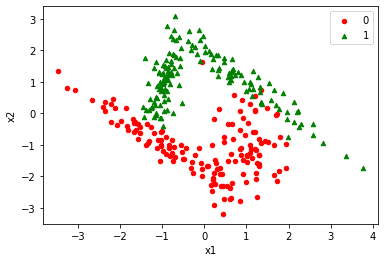

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification


def plot_2D_task(X, y):
    # scatter plot, dots colored by class value
    df = pd.DataFrame(dict(x1=X[:,0], x2=X[:,1], y=y))
    colors = {0:'red', 1:'green'}
    markers = {0: 'o', 1: '^'}
    fig, ax = plt.subplots()
    grouped = df.groupby('y')
    for key, group in grouped:
        group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color=colors[key], marker=markers[key])
    plt.show()

# generate 2d classification dataset
X, y = make_classification(
    n_samples=300,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=2,
    weights = (0.5, 0.5),
    random_state=123
)

plot_2D_task(X, y)

## 1.1. Aplicações em aprendizado de máquina
Algoritmos baseado em distâncias podem ser usados para diversas tarefas de aprendizado de máquina

* Classificação
* Regressão
* Agrupamento
* Imputação de valores faltantes
* Eliminação de Ruído

## 1.2. Tipos de Distâcias
Existem diversos tipos de distâncias que podem ser utilizadas.
É importante entender se a distância faz sentido para o seu problema.

Umas das distâncias mais conhecidas são as distâncias de Minkowski.
* Dado espaço vetorial com norma podemos definir a distância de **Minkowski** como: 
\begin{equation*}
dist( \vec{u}, \vec{v} ) = \Big( \sum_{i=1}^m \left | u_i - v_i \right |^p \Big)^{(\frac{1}{p})}
\end{equation*}


* Para $p = 1$ temos a distância de **Manhattan**: 
\begin{equation*}
dist(\vec{u}, \vec{v}) = \sum_{i=1}^m \left | u_i - v_i \right | 
\end{equation*}

* Para $p = 2$ temos a distância **Euclidiana**: 
\begin{equation*}
dist(\vec{u}, \vec{v}) = \Big( \sum_{i=1}^m \left | u_i - v_i \right |^2 \Big)^{(\frac{1}{2})} = \sqrt{ \sum_{i=1}^m (u_i - v_i)^2}
\end{equation*}

* Para $r = \inf$ temos a distância de **Chebyshev** ou norma máxima:
\begin{equation*}
dist( \vec{u}, \vec{v} ) = \max_{i = 1,~...~, m}(| u_i - v_i |)
\end{equation*}

* Cosseno
\begin{equation*}
dist(\vec{u}, \vec{v}) = cos(\theta) = \frac{ \vec{u} \cdot \vec{v} }{\| \vec{u} \| \| \vec{v} \|} = \frac{ \sum_{i=1}^{m} u_i v_i }{ \sqrt{\sum_{i=1}^{m} u_i^2} \sqrt{\sum_{i=1}^{m} v_i^2} }
\end{equation*}


Observações:
* $u$ e $v$ podem ser vistos como exemplos de um conjunto de dados
* $m$ o número de atributos preditivos


## 1.3. $k$NN para classificação de dados

### 1.3.1. Algoritmo $k$NN clássico

In [2]:
import numpy as np
from scipy import stats


class KNNClassifier:
    def __init__(self, k=3, metric="euclidean", p=2, verbose=False, random_state=0):
        # armazenando valores
        self.k = k
        self.metric = metric
        self.p = p
        self.verbose = verbose
        
        np.random.seed(random_state)
        
        # selecionando qual distancia usar
        self.metric = None
        if metric == "euclidean":
            self.metric_function = self.euclidean
        elif metric == "manhattan":
            self.metric_function = self.manhattan
        elif metric == "chebyshev":
            self.metric_function = self.chebyshev
        elif metric == "minkowski":
            self.metric_function = self.minkowski
        
        if verbose == True:
            print("Algoritmos kNN iniciado.")
            print("  * k      = ", k)
            print("  * metric = ", metric)
            print("  * p      = ", p, "\n")
        
    def euclidean(self, u, v):
        summ = 0
        m = u.shape[0]
        
        for i in range(m):
            summ = summ + (u[i]-v[i])**2
        distance = np.sqrt(summ)
        
        return distance
    
    def manhattan(self, u, v):
        summ = 0
        m = u.shape[0]
        
        for i in range(m):
            summ = summ + np.absolute(u[i]-v[i])
        distance = summ
        
        return distance
         
    def chebyshev(self, u, v):
        return np.max(np.absolute(u-v))
    
    def minkowski(self, u, v):
        p = self.p
        
        return np.power(np.sum(np.power(np.absolute(u-v), p)), 1.0/p)
    
    def get_k_neighbors(self, X_train, query):
        verbose = self.verbose
        k = self.k # k vizinhos
        n = X_train.shape[0] # numero de linhas
        
        # criamos vetor com n zeros
        # vamos salvar todas as distancias aqui
        distances = np.zeros(n) 
        
        for i in range(n): # para cada linha em X
            result = self.metric_function(X_train[i], query) # calcula a distancia para o ponto de consulta
            distances[i] = result
        
        # Essa função ordena as distâncias (crescente) e retorna as linhas
        row_ids = np.argsort(distances)
        
        # pegar apenas os k vizinhos
        k_neighbors_ids = row_ids[0:k]
        
        if verbose == True:
            print("Os k vizinhos são as linhas: ", k_neighbors_ids)
            print("As distancias são: ", np.round(distances[k_neighbors_ids], 2))
        
        return k_neighbors_ids
        
    def fit(self, X_train, y_train):
        verbose = self.verbose
        
        if verbose == True:
            print("Estou com preguiça, não vou gerar modelo.")
            print("Vou salvar os dados apenas!\n")

        self.X_train = X_train
        self.y_train = y_train
        
        return self
        
    
    def predict_proba(self, X_test):
        verbose = self.verbose
        if verbose == True:
            print("Vou pegar os dados que guardei para fazer a predição!\n")
            print("Vou predizer probabilidades!\n")
        
        n = X_test.shape[0] # quantidade de exemplos para predição
        X_train = self.X_train # exemplos do conjunto de treino
        y_train = self.y_train # classes do conjunto de treino
        cls_train = np.unique(y_train) # classes do treino
        n_cls_train = cls_train.shape[0] # numero de classes do treino
        y_predicted = np.zeros((n, n_cls_train), dtype="float") # matriz para colocar resultado

        
        for i in range(n):
            
            if verbose == True:
                print("Predizendo linha [", i, "]")

            # pega os ids das linhas dos k vizinhos mais proximos
            k_neighbors_ids = self.get_k_neighbors(X_train, X_test[i])

            # pega a classe dos k viznhos
            k_neighbors_classes = y_train[k_neighbors_ids]

            # verificar se houve um empate
            cls_test, cls_test_counts = np.unique(k_neighbors_classes, return_counts=True)
                        
            if verbose == True:
                print("Classes = ", cls_test)
                print("Counts = ", cls_test_counts, "\n")
            
            probs = cls_test_counts/np.sum(cls_test_counts)
            
            for j in range(cls_test.shape[0]):
                index = np.where(cls_test[j] == cls_train)[0]
                y_predicted[i][index] = probs[j]

        return y_predicted
    
    def predict(self, X_test):
        verbose = self.verbose
        if verbose == True:
            print("Vou pegar os dados que guardei para fazer a predição!\n")

        n = X_test.shape[0] # quantidade de exemplos para predição
        X_train = self.X_train # exemplos do conjunto de treino
        y_train = self.y_train # classes do conjunto de treino
        y_predicted = np.zeros(n, dtype="int") # vetor para colocar resultado
        
        for i in range(n):
            
            if verbose == True:
                print("Predizendo linha [", i, "]")


            # pega os ids das linhas dos k vizinhos mais proximos
            k_neighbors_ids = self.get_k_neighbors(X_train, X_test[i])

            # pega a classe dos k viznhos
            k_neighbors_classes = y_train[k_neighbors_ids]

            # verificar se houve um empate
            classes, counts = np.unique(k_neighbors_classes, return_counts=True)
            is_tie = np.all(counts == counts[0]) and classes.shape[0] > 1
            
            if verbose == True:
                print("Classes = ", classes)
                print("Counts = ", counts, "\n")

            if is_tie:  # se sim, chutar uma das classes
                if verbose == True:
                    print("Houve um empate!\n")
                new_class = np.random.choice(classes).reshape(1,) 

            else: # se nao, calcula a moda
                new_class = stats.mode(k_neighbors_classes)[0]
                
            y_predicted[i] = new_class

        return y_predicted
        
    
X_train = np.array([[1,1], [2,2], [15,15], [12, 12], [13, 13]])
y_train = np.array([0, 0, 1, 1, 2])
X_test = np.array([[3, 3], [16,16]]) 

clsf = KNNClassifier(k=2, metric="euclidean", verbose=1)
clsf.fit(X_train, y_train)
print("--> classe predita: ", clsf.predict(X_test), "\n")

clsf = KNNClassifier(k=3, metric="euclidean", verbose=1)
clsf.fit(X_train, y_train)
print("--> classe predita: ", clsf.predict(X_test), "\n")

clsf = KNNClassifier(k=3, metric="minkowski", p=2, verbose=1)
clsf.fit(X_train, y_train)
print("--> classe predita: ", clsf.predict(X_test), "\n")

clsf = KNNClassifier(k=3, metric="manhattan", verbose=1)
clsf.fit(X_train, y_train)
print("--> classe predita: ", clsf.predict(X_test), "\n")

clsf = KNNClassifier(k=3, metric="minkowski", p=1, verbose=1)
clsf.fit(X_train, y_train)
print("--> classe predita: ", clsf.predict(X_test), "\n")

clsf = KNNClassifier(k=3, metric="chebyshev", verbose=1)
clsf.fit(X_train, y_train)
print("--> classe predita: ", clsf.predict(X_test), "\n")

clsf = KNNClassifier(k=5, metric="chebyshev", verbose=1)
clsf.fit(X_train, y_train)
print("--> classe predita: ", clsf.predict_proba(X_test), "\n")


Algoritmos kNN iniciado.
  * k      =  2
  * metric =  euclidean
  * p      =  2 

Estou com preguiça, não vou gerar modelo.
Vou salvar os dados apenas!

Vou pegar os dados que guardei para fazer a predição!

Predizendo linha [ 0 ]
Os k vizinhos são as linhas:  [1 0]
As distancias são:  [1.41 2.83]
Classes =  [0]
Counts =  [2] 

Predizendo linha [ 1 ]
Os k vizinhos são as linhas:  [2 4]
As distancias são:  [1.41 4.24]
Classes =  [1 2]
Counts =  [1 1] 

Houve um empate!

--> classe predita:  [0 1] 

Algoritmos kNN iniciado.
  * k      =  3
  * metric =  euclidean
  * p      =  2 

Estou com preguiça, não vou gerar modelo.
Vou salvar os dados apenas!

Vou pegar os dados que guardei para fazer a predição!

Predizendo linha [ 0 ]
Os k vizinhos são as linhas:  [1 0 3]
As distancias são:  [ 1.41  2.83 12.73]
Classes =  [0 1]
Counts =  [2 1] 

Predizendo linha [ 1 ]
Os k vizinhos são as linhas:  [2 4 3]
As distancias são:  [1.41 4.24 5.66]
Classes =  [1 2]
Counts =  [2 1] 

--> classe predita

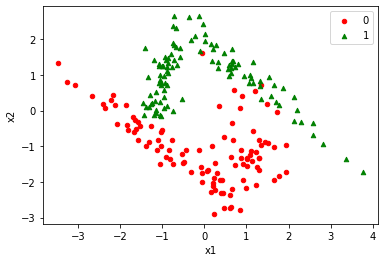

In [3]:
X_train, y_train = X[:210], y[:210] # 70% para treino
X_test, y_test = X[210:], y[210:] # 30% para teste

# plotar limpeza
plot_2D_task(X_train, y_train)

Distância Euclidiana:

In [4]:
clsf = KNNClassifier(k=3, metric="euclidean")
clsf.fit(X_train, y_train)
pred = clsf.predict(X_test)

acc = np.sum(y_test == pred)/pred.shape[0] 
print("Acurácia: ", acc)

Acurácia:  0.9555555555555556


Distância Manhattan:

In [5]:
clsf = KNNClassifier(k=3, metric="manhattan")
clsf.fit(X_train, y_train)
pred = clsf.predict(X_test)

acc = np.sum(y_test == pred)/pred.shape[0] 
print("Acurácia: ", acc)

Acurácia:  0.9666666666666667


Distância Chebyshev:

In [6]:
clsf = KNNClassifier(k=3, metric="chebyshev")
clsf.fit(X_train, y_train)
pred = clsf.predict(X_test)

acc = np.sum(y_test == pred)/pred.shape[0] 
print("Acurácia: ", acc)

Acurácia:  0.9666666666666667


Distância Minkowski:

In [7]:
clsf = KNNClassifier(k=3, metric="minkowski", p=0.7)
clsf.fit(X_train, y_train)
pred = clsf.predict(X_test)

acc = np.sum(y_test == pred)/pred.shape[0] 
print("Acurácia: ", acc)

Acurácia:  0.9777777777777777


 Distância Minkowski:

In [8]:
clsf = KNNClassifier(k=3, metric="minkowski", p=4)
clsf.fit(X_train, y_train)
pred = clsf.predict(X_test)

acc = np.sum(y_test == pred)/pred.shape[0] 
print("Acurácia: ", acc)

Acurácia:  0.9666666666666667


### 1.3.2. Algoritmo Edit $k$NN com eliminação sequencial

Diminuir o conjunto de dados evitando duplicados e removendo ruído.

Também ajuda a remover dados ruidosos na fronteira de decisão.

<img src="img/edit_knn_eliminacao_seq.png" width="600">
<center>Edit kNN com eliminação sequencial. Fonte: livro base.</center>

### 1.3.3. Algoritmo Edit $k$NN com inserção sequencial

Diminuir o conjunto de dados evitando duplicatas.

Também ajuda a remover dados ruidosos na fronteira de decisão.

<img src="img/edit_knn_insercao_seq.png" width="600">
<center>Edit kNN com inserção sequencial. Fonte: livro base.</center>

### 1.3.3. Implementação do algoritmo Edit 𝑘NN

In [9]:
import numpy as np
from scipy import stats


class EditKNNClassifier:
    def __init__(self, k=3, metric="euclidean", p=2, cleaning=None,
                 alg=None, verbose=False, initial=1, random_state=0):
        # armazenando valores
        self.k = k
        self.p = p
        self.verbose = verbose
        self.initial = initial
        
        np.random.seed(random_state)
        
        # selecionando qual distancia usar
        self.metric = None
        if metric == "euclidean":
            self.metric_function = self.euclidean
        elif metric == "manhattan":
            self.metric_function = self.manhattan
        elif metric == "chebyshev":
            self.metric_function = self.chebyshev
        elif metric == "minkowski":
            self.metric_function = self.minkowski
        
        # selecionando o tipo de limpeza
        self.cleaning = None
        if cleaning == "elimination":
            self.cleaning = self.cleaning_elimination
        elif cleaning == "insertion":
            self.cleaning = self.cleaning_insertion
        elif cleaning == None:
            self.cleaning = self.cleaning_none
        
        # selecionando algoritmo de classificacao para limpeza
        if alg is None:
            self.alg = KNNClassifier(k=3, metric="euclidean")
        else:
            self.alg = alg
        
        if verbose == True:
            print("Algoritmos kNN iniciado.")
            print("  * k        = ", k)
            print("  * metric   = ", metric)
            print("  * p        = ", p)
            print("  * cleaning = ", cleaning, "\n")
            
    def cleaning_insertion(self, X_train, y_train):
        verbose = self.verbose
        n = X_train.shape[0] # numero de linhas
        alg = self.alg # algoritmo de classificacao
        initial = self.initial # quantidade inicial de exemplo
        
        # restante do conjunto fica na variavel auxiliar
        X_train_aux = X_train[initial:]
        y_train_aux = y_train[initial:]
        
        # cria conjunto com apenas 2 exemplo
        X_train = X_train[:initial]
        y_train = y_train[:initial]
        
        for i in range(n-initial):
            xi = X_train_aux[:1] # pega exemplo do topo
            yi = y_train_aux[:1]
            
            X_train_aux = X_train_aux[1:] # remove do conjunto de trainamento
            y_train_aux = y_train_aux[1:]

            if verbose == True:
                print(X_train.shape, y_train.shape)

            # tenta predizer
            clasf = alg.fit(X_train, y_train)
            yi_pred = clasf.predict(xi)
            
            if yi_pred[0] != yi[0]: # se não sao iguais adiciona novamente no fim do conjunto de dados
                X_train = np.append(X_train, xi, axis=0)
                y_train = np.append(y_train, yi, axis=0)
                
        if verbose == True:
            print(X_train.shape, y_train.shape)

        return X_train, y_train

    def cleaning_elimination(self, X_train, y_train):
        verbose = self.verbose
        n = X_train.shape[0] # numero de linhas
        alg = self.alg # algoritmo de classificacao
        initial = self.initial # quantidade inicial de exemplo

        for i in range(n):
            xi = X_train[:1] # pega exemplo do topo
            yi = y_train[:1]
            
            X_train = X_train[1:] # remove do conjunto de trainamento
            y_train = y_train[1:]
            
            if verbose == True:
                print(X_train.shape, y_train.shape)

            # tenta predizer
            clasf = alg.fit(X_train, y_train)
            yi_pred = clasf.predict(xi)
            
            if yi_pred[0] != yi[0]: # se não sao iguais adiciona novamente no fim do conjunto de dados
                X_train = np.append(X_train, xi, axis=0)
                y_train = np.append(y_train, yi, axis=0)
                
        if verbose == True:
            print(X_train.shape, y_train.shape)

        return X_train, y_train
    
    def cleaning_none(self, X_train, y_train):
        return X_train, y_train
        
    def euclidean(self, u, v):
        summ = 0
        m = u.shape[0]
        
        for i in range(m):
            summ = summ + (u[i]-v[i])**2
        distance = np.sqrt(summ)
        
        return distance
    
    def manhattan(self, u, v):
        summ = 0
        m = u.shape[0]
        
        for i in range(m):
            summ = summ + np.absolute(u[i]-v[i])
        distance = summ
        
        return distance
         
    def chebyshev(self, u, v):
        return np.max(np.absolute(u-v))
    
    def minkowski(self, u, v):
        p = self.p
        
        return np.power(np.sum(np.power(np.absolute(u-v), p)), 1.0/p)
    
    def get_k_neighbors(self, X_train, query):
        verbose = self.verbose
        k = self.k # k vizinhos
        n = X_train.shape[0] # numero de linhas
        
        # criamos vetor com n zeros
        # vamos salvar todas as distancias aqui
        distances = np.zeros(n) 
        
        for i in range(n): # para cada linha em X
            result = self.metric_function(X_train[i], query) # calcula a distancia para o ponto de consulta
            distances[i] = result
        
        # Essa função ordena as distâncias (crescente) e retorna as linhas
        row_ids = np.argsort(distances)
        
        # pegar apenas os k vizinhos
        k_neighbors_ids = row_ids[0:k]
        
        if verbose == True:
            print("Os k vizinhos são as linhas: ", k_neighbors_ids)
            print("As distancias são: ", np.round(distances[k_neighbors_ids], 2))
        
        return k_neighbors_ids
        
    def fit(self, X_train, y_train):
        verbose = self.verbose
        
        if verbose == True:
            print("Estou com preguiça, não vou gerar modelo.")
            print("Vou salvar os dados apenas!")

        self.X_train, self.y_train = self.cleaning(X_train, y_train)
        
        if verbose == True:
            print("Shape dos dados antes da limpeza: ", X_train.shape)
            print("Shape dos dados depois da limpeza: ", self.X_train.shape, "\n")
        
        return self
        
    def predict(self, X_test):
        if X_test.shape[1] != self.X_train.shape[1]:
            raise Exception("Numero de atributos diferentes!")
            
        verbose = self.verbose
        if verbose == True:
            print("Vou pegar os dados que guardei para fazer a predição!\n")

        n = X_test.shape[0] # quantidade de exemplos para predição
        X_train = self.X_train # exemplos do conjunto de treino
        y_train = self.y_train # classes do conjunto de treino
        y_predicted = np.zeros(n, dtype="int") # vetor para colocar resultado
        
        for i in range(n):
            
            if verbose == True:
                print("Predizendo linha [", i, "]")


            # pega os ids das linhas dos k vizinhos mais proximos
            k_neighbors_ids = self.get_k_neighbors(X_train, X_test[i])

            # pega a classe dos k viznhos
            k_neighbors_classes = y_train[k_neighbors_ids]

            # verificar se houve um empate
            classes, counts = np.unique(k_neighbors_classes, return_counts=True)
            is_tie = np.all(counts == counts[0]) and classes.shape[0] > 1
            
            if verbose == True:
                print("Classes = ", classes)
                print("Counts = ", counts, "\n")

            if is_tie:  # se sim, chutar uma das classes
                if verbose == True:
                    print("Houve um empate!\n")
                new_class = np.random.choice(classes).reshape(1,) 

            else: # se nao, calcula a moda
                new_class = stats.mode(k_neighbors_classes)[0]
                
            y_predicted[i] = new_class

        return y_predicted

Toy dataset

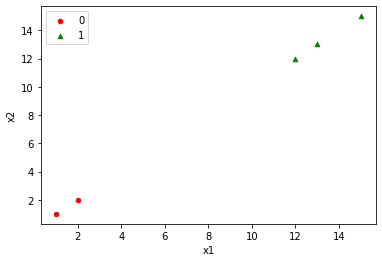

In [10]:
X_train = np.array([[1,1], [2,2], [15,15], [12, 12], [13, 13]])
y_train = np.array([0, 0, 1, 1, 1])
X_test = np.array([[3, 3], [16,16]])

plot_2D_task(X_train, y_train)

Eliminação:

In [11]:
clsf = EditKNNClassifier(k=3, metric="euclidean", cleaning="elimination", verbose=1)
clsf = clsf.fit(X_train, y_train)

Algoritmos kNN iniciado.
  * k        =  3
  * metric   =  euclidean
  * p        =  2
  * cleaning =  elimination 

Estou com preguiça, não vou gerar modelo.
Vou salvar os dados apenas!
(4, 2) (4,)
(4, 2) (4,)
(4, 2) (4,)
(3, 2) (3,)
(3, 2) (3,)
(4, 2) (4,)
Shape dos dados antes da limpeza:  (5, 2)
Shape dos dados depois da limpeza:  (4, 2) 



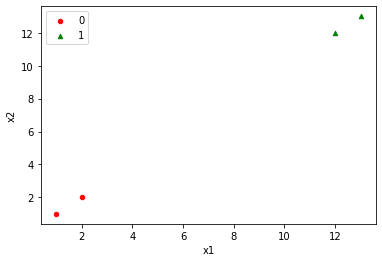

In [12]:
plot_2D_task(clsf.X_train, clsf.y_train)

In [13]:
print("--> classe predita: ", clsf.predict(X_test), "\n")

Vou pegar os dados que guardei para fazer a predição!

Predizendo linha [ 0 ]
Os k vizinhos são as linhas:  [1 0 2]
As distancias são:  [ 1.41  2.83 12.73]
Classes =  [0 1]
Counts =  [2 1] 

Predizendo linha [ 1 ]
Os k vizinhos são as linhas:  [3 2 1]
As distancias são:  [ 4.24  5.66 19.8 ]
Classes =  [0 1]
Counts =  [1 2] 

--> classe predita:  [0 1] 



Inserção:

In [14]:
clsf = EditKNNClassifier(k=3, metric="euclidean", cleaning="insertion", verbose=1)
clsf = clsf.fit(X_train, y_train)

Algoritmos kNN iniciado.
  * k        =  3
  * metric   =  euclidean
  * p        =  2
  * cleaning =  insertion 

Estou com preguiça, não vou gerar modelo.
Vou salvar os dados apenas!
(1, 2) (1,)
(1, 2) (1,)
(2, 2) (2,)
(3, 2) (3,)
(3, 2) (3,)
Shape dos dados antes da limpeza:  (5, 2)
Shape dos dados depois da limpeza:  (3, 2) 



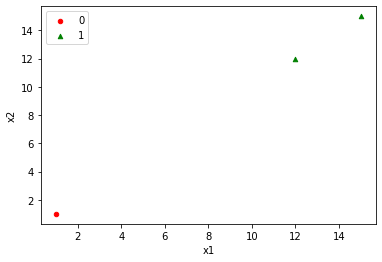

In [15]:
plot_2D_task(clsf.X_train, clsf.y_train)

In [16]:
print("--> classe predita: ", clsf.predict(X_test), "\n")

Vou pegar os dados que guardei para fazer a predição!

Predizendo linha [ 0 ]
Os k vizinhos são as linhas:  [0 2 1]
As distancias são:  [ 2.83 12.73 16.97]
Classes =  [0 1]
Counts =  [1 2] 

Predizendo linha [ 1 ]
Os k vizinhos são as linhas:  [1 2 0]
As distancias são:  [ 1.41  5.66 21.21]
Classes =  [0 1]
Counts =  [1 2] 

--> classe predita:  [1 1] 



### Com eliminação

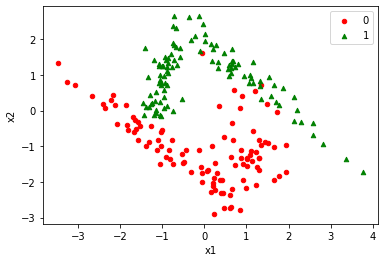

In [17]:
X_train, y_train = X[:210], y[:210] # 70% para treino
X_test, y_test = X[210:], y[210:] # 30% para teste

# plotar limpeza
plot_2D_task(X_train, y_train)

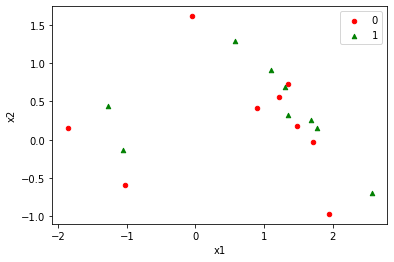

In [18]:
clsf = EditKNNClassifier(k=3, metric="euclidean", cleaning="elimination")
clsf.fit(X_train, y_train)
plot_2D_task(clsf.X_train, clsf.y_train)

pred = clsf.predict(X_test)

In [19]:
acc = np.sum(y_test == pred)/pred.shape[0] 
print("Acurácia: ", acc)

Acurácia:  0.8


### Com inserção

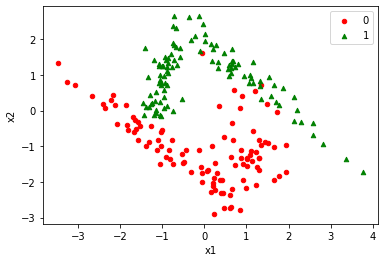

In [20]:
X_train, y_train = X[:210], y[:210] # 70% para treino
X_test, y_test = X[210:], y[210:] # 30% para teste

# plotar limpeza
plot_2D_task(X_train, y_train)


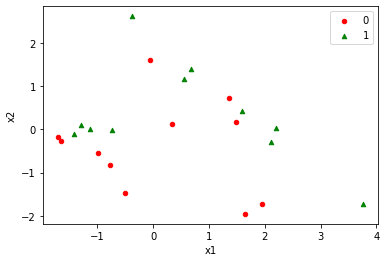

In [21]:
clsf = EditKNNClassifier(k=3, metric="euclidean", cleaning="insertion")
clsf.fit(X_train, y_train)
plot_2D_task(clsf.X_train, clsf.y_train)

pred = clsf.predict(X_test)

In [22]:
acc = np.sum(y_test == pred)/pred.shape[0] 
print("Acurácia: ", acc)

Acurácia:  0.9222222222222223


### Com inserção parcial

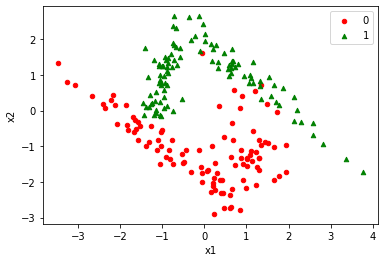

In [23]:
X_train, y_train = X[:210], y[:210] # 70% para treino
X_test, y_test = X[210:], y[210:] # 30% para teste

# plotar limpeza
plot_2D_task(X_train, y_train)

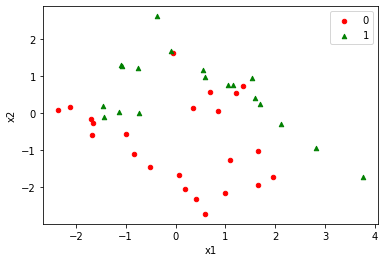

In [24]:
clsf = EditKNNClassifier(k=3, metric="euclidean", cleaning="insertion", initial=30)
clsf.fit(X_train, y_train)
plot_2D_task(clsf.X_train, clsf.y_train)

pred = clsf.predict(X_test)

In [25]:
acc = np.sum(y_test == pred)/pred.shape[0] 
print("Acurácia: ", acc)

Acurácia:  0.9888888888888889


### 1.3.3. Aspectos Positivos e Negativos

Positivos:
* O conceito é simples e fácil de ser implementado
* É aplicavel mesmo para problemas complexos
* É naturalmente incremental
* Constroi aproximações locais da função objetivo, pode ser vantajoso quando a função é muito complexa

Negativos:
* Não temos uma representção compacta, pois não há um modelo
* Predição pode ser custosa
* É afetado por atributos redundantes e ruído
* Problema para lidar com alta dimensionalidade

### 1.3.4. Dicas

Evite usar valores de $k$ que levem a um cenário de indecisão.

* Evite usar $k \leq $ número de classes ou multiplo de k
* Uma boa opção são números primos (>2)


## $k$NN para regressão de dados

In [26]:
import numpy as np
from scipy import stats


class KNNRegressor:
    def __init__(self, k=3, metric="euclidean", p=2, verbose=False, random_state=0):
        # armazenando valores
        self.k = k
        self.metric = metric
        self.p = p
        self.verbose = verbose
        
        np.random.seed(random_state)
        
        # selecionando qual distancia usar
        self.metric = None
        if metric == "euclidean":
            self.metric_function = self.euclidean
        elif metric == "manhattan":
            self.metric_function = self.manhattan
        elif metric == "chebyshev":
            self.metric_function = self.chebyshev
        elif metric == "minkowski":
            self.metric_function = self.minkowski
        
        if verbose == True:
            print("Algoritmos kNN iniciado.")
            print("  * k      = ", k)
            print("  * metric = ", metric)
            print("  * p      = ", p, "\n")
        
    def euclidean(self, u, v):
        summ = 0
        m = u.shape[0]
        
        for i in range(m):
            summ = summ + (u[i]-v[i])**2
        distance = np.sqrt(summ)
        
        return distance
    
    def manhattan(self, u, v):
        summ = 0
        m = u.shape[0]
        
        for i in range(m):
            summ = summ + np.absolute(u[i]-v[i])
        distance = summ
        
        return distance
         
    def chebyshev(self, u, v):
        return np.max(np.absolute(u-v))
    
    def minkowski(self, u, v):
        p = self.p
        
        return np.power(np.sum(np.power(np.absolute(u-v), p)), 1.0/p)
    
    def get_k_neighbors(self, X_train, query):
        verbose = self.verbose
        k = self.k # k vizinhos
        n = X_train.shape[0] # numero de linhas
        
        # criamos vetor com n zeros
        # vamos salvar todas as distancias aqui
        distances = np.zeros(n) 
        
        for i in range(n): # para cada linha em X
            result = self.metric_function(X_train[i], query) # calcula a distancia para o ponto de consulta
            distances[i] = result
        
        # Essa função ordena as distâncias (crescente) e retorna as linhas
        row_ids = np.argsort(distances)
        
        # pegar apenas os k vizinhos
        k_neighbors_ids = row_ids[0:k]
        
        if verbose == True:
            print("Os k vizinhos são as linhas: ", k_neighbors_ids)
            print("As distancias são: ", np.round(distances[k_neighbors_ids], 2))
        
        return k_neighbors_ids
        
    def fit(self, X_train, y_train):
        verbose = self.verbose
        
        if verbose == True:
            print("Estou com preguiça, não vou gerar modelo.")
            print("Vou salvar os dados apenas!\n")

        self.X_train = X_train
        self.y_train = y_train
        
        return self
            
    def predict(self, X_train):
        verbose = self.verbose
        if verbose == True:
            print("Vou pegar os dados que guardei para fazer a predição!\n")

        n = X_test.shape[0] # quantidade de exemplos para predição
        X_train = self.X_train # exemplos do conjunto de treino
        y_train = self.y_train # valores alvo do conjunto de treino
        y_predicted = np.zeros(n, dtype="float") # vetor para colocar resultado
        
        for i in range(n):
            if verbose == True:
                print("Predizendo linha [", i, "]")

            # pega os ids das linhas dos k vizinhos mais proximos
            k_neighbors_ids = self.get_k_neighbors(X_train, X_test[i])

            # pega os valores dos k viznhos
            k_neighbors_values = y_train[k_neighbors_ids]
           
            if verbose == True:
                print("Values = ", np.round(k_neighbors_values, 2), "\n")

            new_value = np.mean(k_neighbors_values)
            y_predicted[i] = new_value

        return y_predicted
        

Toy dataset

In [27]:
X_train = np.array([[1,1], [2,2], [15,15], [12, 12], [13, 13]])
y_train = np.array([0.5, 0.7, 1.2, 1.7, 2.1])
X_test = np.array([[3, 3], [16,16]])

Para k = 2:

In [28]:
clsf = KNNRegressor(k=2, metric="euclidean", verbose=1)
clsf = clsf.fit(X_train, y_train)

Algoritmos kNN iniciado.
  * k      =  2
  * metric =  euclidean
  * p      =  2 

Estou com preguiça, não vou gerar modelo.
Vou salvar os dados apenas!



In [29]:
print("--> classe predita: ", clsf.predict(X_test), "\n")

Vou pegar os dados que guardei para fazer a predição!

Predizendo linha [ 0 ]
Os k vizinhos são as linhas:  [1 0]
As distancias são:  [1.41 2.83]
Values =  [0.7 0.5] 

Predizendo linha [ 1 ]
Os k vizinhos são as linhas:  [2 4]
As distancias são:  [1.41 4.24]
Values =  [1.2 2.1] 

--> classe predita:  [0.6  1.65] 



Para k = 3:

In [30]:
clsf = KNNRegressor(k=3, metric="euclidean", verbose=1)
clsf = clsf.fit(X_train, y_train)

Algoritmos kNN iniciado.
  * k      =  3
  * metric =  euclidean
  * p      =  2 

Estou com preguiça, não vou gerar modelo.
Vou salvar os dados apenas!



In [31]:
print("--> classe predita: ", clsf.predict(X_test), "\n")

Vou pegar os dados que guardei para fazer a predição!

Predizendo linha [ 0 ]
Os k vizinhos são as linhas:  [1 0 3]
As distancias são:  [ 1.41  2.83 12.73]
Values =  [0.7 0.5 1.7] 

Predizendo linha [ 1 ]
Os k vizinhos são as linhas:  [2 4 3]
As distancias são:  [1.41 4.24 5.66]
Values =  [1.2 2.1 1.7] 

--> classe predita:  [0.96666667 1.66666667] 



## DWNN para classificação de dados

É possível ponderar pelas distâncias
Intuição: